# 필수 라이브러리 임포트

In [1]:
# 필수 라이브러리
!pip install --upgrade joblib==1.1.0
!pip install --upgrade scikit-learn==1.1.3
!pip install mglearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.0/307.0 kB 4.7 MB/s eta 0:00:00
  Attempting uninstall: joblib
    Found existing installation: joblib 1.4.2
    Uninstalling joblib-1.4.2:
      Successfully uninstalled joblib-1.4.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scikit-learn 1.6.1 requires joblib>=1.2.0, but you have joblib 1.1.0 which is incompatible.
imbalanced-learn 0.13.0 requires joblib<2,>=1.1.1, but you have joblib 1.1.0 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.0/32.0 MB 41.2 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the fol

In [2]:
import logging

logging.getLogger('matplotlib.font_manager').setLevel(logging.ERROR)

In [3]:
import mglearn

from sklearn.model_selection import train_test_split

In [4]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl
# import matplotlib.font_manager as fm
import seaborn as sns

# 브라우저에서 바로 그려지도록
%matplotlib inline

# 차원의 저주(The curse of dimensionality)
- 데이터 학습을 위해 차원이 증가하면서 학습데이터 수가 차원의 수보다 적어져 성능이 저하되는 현상
- 차원이 증가할 수록 개별 차원 내 학습할 데이터 수가 적어지는(sparse) 현상 발생  

해결책은 차원을 축소하거나 데이터를 더 많이 수집해야함.

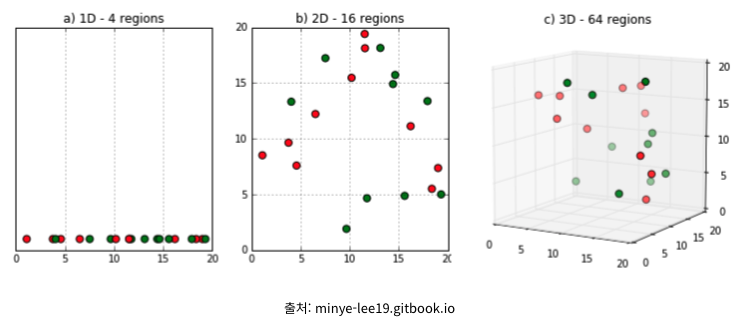

상기 이미지와 같이 데이터양은 동일하지만 차원만 늘어나면 빈공간이 많아지는 것을 볼 수 있다.  
이것은 데이터 상에 0값으로 채워진 부분이 늘어난다는 뜻이다. 따라서 모델이 학습할 때, 상대적으로 데이터가 적어지므로, 성능이 저하될 수 밖에 없다.   

특히 KNN과 같이 특정 알고리즘은 성능저하가 매우 심각해진다.

## KNN을 이용한 예제

In [5]:
import os
import numpy as np
import random
import torch

def reset_seeds(seed=42):
  random.seed(seed)
  os.environ['PYTHONHASHSEED'] = str(seed)    # 파이썬 환경변수 시드 고정
  np.random.seed(seed)
  torch.manual_seed(seed) # cpu 연산 무작위 고정
  torch.cuda.manual_seed(seed) # gpu 연산 무작위 고정
  torch.backends.cudnn.deterministic = True  # cuda 라이브러리에서 Deterministic(결정론적)으로 예측하기 (예측에 대한 불확실성 제거 )


In [6]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder

In [7]:
X, y = mglearn.datasets.make_forge()
X_tr, X_te, y_tr, y_te = train_test_split(X, y, random_state=0)

In [8]:
X_tr.shape

(19, 2)

In [9]:
clf = KNeighborsClassifier(n_neighbors=3).fit(X_tr, y_tr)
print(f'훈련용 평가지표: {clf.score(X_tr, y_tr)} / 테스트용 평가지표: {clf.score(X_te, y_te)}')

훈련용 평가지표: 0.9473684210526315 / 테스트용 평가지표: 0.8571428571428571


In [10]:
print(f'before: {X.shape}')
enc = OneHotEncoder()
X_enc = enc.fit_transform(X)
print(f'after: {X_enc.shape}')

before: (26, 2)
after: (26, 52)


In [11]:
X_tr_enc, X_te_enc, y_tr, y_te = train_test_split(X_enc, y, random_state=0)

In [12]:
clf = KNeighborsClassifier(n_neighbors=3).fit(X_tr_enc, y_tr)
print(f'훈련용 평가지표: {clf.score(X_tr_enc, y_tr)} / 테스트용 평가지표: {clf.score(X_te_enc, y_te)}')


훈련용 평가지표: 0.9473684210526315 / 테스트용 평가지표: 0.42857142857142855


상기 결과를 보듯이 차원이 너무 많은 경우, 오버피팅이 발생하여 테스트용 평가지표가 매우 낮게 나타난 것을 확인할 수 있었다.

# 데이터 로드

In [13]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from lightgbm import LGBMClassifier

import seaborn as sns

SEED = 42

/usr/local/lib/python3.11/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [14]:
df = sns.load_dataset('titanic')

df.shape

(891, 15)

In [15]:
y_train = df["survived"] # 정답값
df = df.drop('survived', axis=1) # 정답값 제외
df.shape, y_train.shape

((891, 14), (891,))

In [16]:
# 결측치 미리 채우기
df.age = df.age.fillna(df.age.median()) # age 중앙값
df.deck = df.deck.fillna(df.deck.mode()[0]) # deck 최빈값
df.embarked = df.embarked.fillna(df.embarked.mode()[0]) # embarked 최빈값
df.embark_town = df.embark_town.fillna(df.embark_town.mode()[0]) # embark_town 최빈값

df.isnull().sum().sum()

0

In [17]:
df.head()

,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,3,male,22.0,1,0,7.2500,S,Third,man,True,C,Southampton,no,False
1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,3,female,26.0,0,0,7.9250,S,Third,woman,False,C,Southampton,yes,True
3,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,3,male,35.0,0,0,8.0500,S,Third,man,True,C,Southampton,no,True


In [18]:
# 학습에 바로 사용가능한 특성
cols = ["age","fare"]
features = df[cols]

In [19]:
df['new1_age'] = df['age'].map(lambda x: x // 2)
df['new2_age'] = df['age'].map(lambda x: x % 2)
df['new1_fare'] = df['fare'].map(lambda x: x // 2)
df['new2_fare'] = df['fare'].map(lambda x: x % 2)

In [20]:
reset_seeds()

print(f'before: {df.shape}')
# 범주형 one-hot encoding
cols = list(set(df.columns) - set(cols))
enc = OneHotEncoder()
sparse_features = pd.DataFrame(
    enc.fit_transform(df[cols]).toarray(),
    columns = enc.get_feature_names_out()
)
x_train = pd.concat([features,sparse_features],axis=1) # 특성
print(f'after: {x_train.shape}')
x_train.head()

before: (891, 18)
after: (891, 332)


,age,fare,pclass_1,pclass_2,pclass_3,alive_no,alive_yes,sibsp_0,sibsp_1,sibsp_2,...,new2_fare_1.9000000000000004,new2_fare_1.9249999999999998,new2_fare_1.9250000000000007,new2_fare_1.9292000000000016,new2_fare_1.9582999999999942,new2_fare_1.9666999999999994,new2_fare_1.9791999999999987,class_First,class_Second,class_Third
0,22.0,7.2500,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,38.0,71.2833,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,26.0,7.9250,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,35.0,53.1000,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,35.0,8.0500,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


## Base model

In [21]:
reset_seeds()

model = KNeighborsClassifier(n_neighbors=10) #LGBMClassifier(random_state=SEED)
cv = KFold(n_splits=5,shuffle=True,random_state=SEED)

scores = cross_val_score(model, x_train, y_train, cv = cv , scoring="roc_auc", n_jobs=-1)
base_score = scores.mean()
base_score

0.815763031045441

# [주성분 분석(PCA; Principal component Analysis)](https://angeloyeo.github.io/2019/07/27/PCA.html#google_vignette)
공분산 행렬은 일종의 행렬로써, 데이터의 구조를 설명해주며, 특히 특징 쌍(feature pairs)들의 변동이 얼마나 닮았는가(다른 말로는 얼마만큼이나 함께 변하는가)를 행렬에 나타내고 있다.
- `고유 벡터(Component)`는 그 행렬이 벡터에 작용하는 주축(principal axis)의 방향을 나타내므로 공분산 행렬의 `고유 벡터(Component)`는 데이터가 어떤 방향으로 분산되어 있는지를 나타내준다고 할 수 있다.
- 고유 값은 `고유 벡터(Component)` 방향으로 얼마만큼의 크기로 벡터공간이 늘려지는 지를 예기한다. 따라서 고유 값이 큰 순서대로 `고유 벡터(Component)`를 정렬하면 결과적으로 중요한 순서대로 주성분을 구하는 것이 된다.

[공분산이란?](https://cyber0946.tistory.com/113)
- 공분산은 X의 편차와 Y의 편차를 곱한것의 평균이라는 뜻이다.

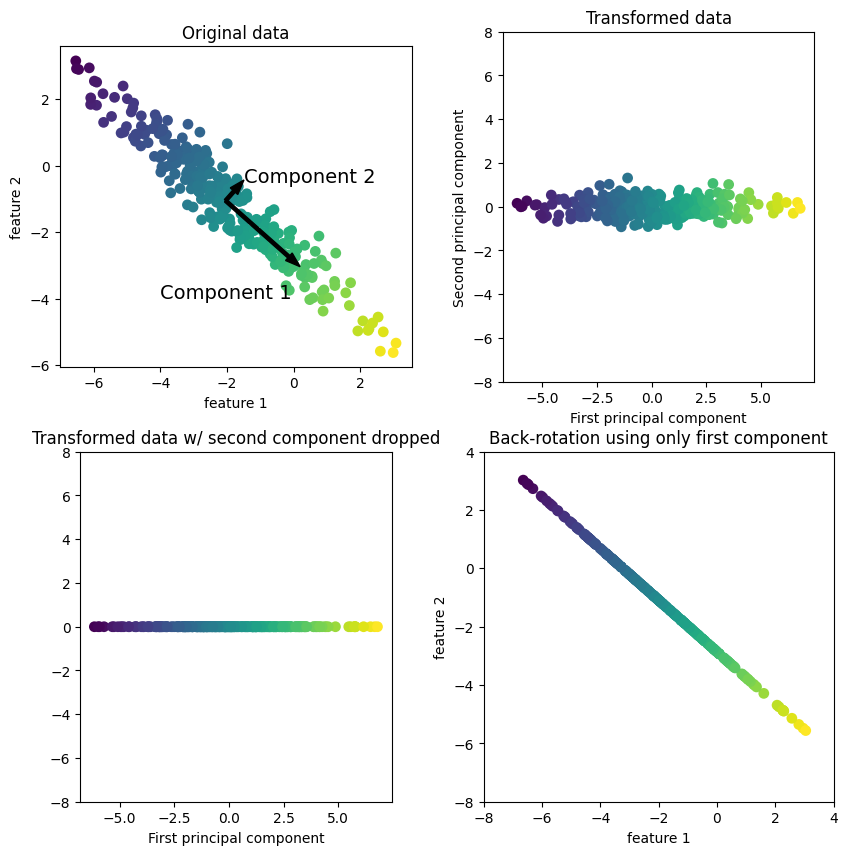

In [22]:
mglearn.plots.plot_pca_illustration()

## Base model(주성분 22)
- 주요 파라미터
  - n_components: 주성분의 수

In [23]:
from sklearn.decomposition import PCA

- 총 features 수

In [24]:
sparse_features.shape[1]

330

In [25]:
reset_seeds()

pca = PCA(n_components=sparse_features.shape[1])
pca.fit(sparse_features) # 주성분 학습
sum(pca.explained_variance_ratio_)

0.9999999999999999

In [26]:
# pca.transform() -> 예측(변환)
tmp = pd.DataFrame(pca.transform(sparse_features)).add_prefix("pca_")
# features(수치형 데이터) -> age, fare
# tmp(범주형 데이터) -> pca를 이용해서 차원 축소(변환)
x_train = pd.concat([features,tmp],axis=1)
print(f'after: {x_train.shape}')

after: (891, 332)


In [27]:
reset_seeds()

model = KNeighborsClassifier(n_neighbors=10)
scores = cross_val_score(model,x_train,y_train,cv = cv , scoring="roc_auc",n_jobs=-1)
print(f'score: {scores.mean()} / base_score: {base_score}')

score: 0.8156840375705949 / base_score: 0.815763031045441


## 주성분 2인 경우
- 변수를 2개로 줄였지만 성능은 같음  

In [28]:
reset_seeds()

pca2 = PCA(n_components=2)
# sparse_features(범주형 데이터) & features(수치형 데이터)
pca2.fit(sparse_features) # 범주형 데이터를 이용해서 pca학습 진행

# 주성분에 의해 설명되는 분산비율
sum(pca2.explained_variance_ratio_)

0.30258569160962556

In [29]:
# tmp.shape -> (row, 2)
tmp = pd.DataFrame(pca2.transform(sparse_features)).add_prefix("pca_")
# features(수치형 데이터) -> age, fare
# tmp(범주형 데이터) -> pca를 이용해서 차원 축소(변환)
x_train = pd.concat([features,tmp],axis=1)
print(f'after: {x_train.shape}')

after: (891, 4)


In [30]:
reset_seeds()

model = KNeighborsClassifier(n_neighbors=10)
scores = cross_val_score(model,x_train,y_train,cv = cv , scoring="roc_auc",n_jobs=-1)
print(f'score: {scores.mean()} / base_score: {base_score}')

score: 0.797416401065853 / base_score: 0.815763031045441


## 주성분 15인 경우
- 변수를 15개로 줄였지만, 성능은 가장 좋지 않음
- 즉, 무조건 줄인다고 좋은 성능을 얻을 수 있지 않음

In [31]:
reset_seeds()

pca15 = PCA(n_components=15)
pca15.fit(sparse_features)
# 주성분에 의해 설명되는 분산비율
sum(pca15.explained_variance_ratio_)

0.7362242170187994

In [32]:
tmp = pd.DataFrame(pca15.transform(sparse_features)).add_prefix("pca_")
x_train = pd.concat([features,tmp],axis=1)
print(f'after: {x_train.shape}')

after: (891, 17)


In [33]:
reset_seeds()

model = KNeighborsClassifier(n_neighbors=10)
scores = cross_val_score(model,x_train,y_train,cv = cv , scoring="roc_auc", n_jobs=-1)
print(f'score: {scores.mean()} / base_score: {base_score}')

score: 0.8257991549587771 / base_score: 0.815763031045441


# [특이값 분해(SVD; Singular Value Decomposition)](https://bkshin.tistory.com/entry/%EB%A8%B8%EC%8B%A0%EB%9F%AC%EB%8B%9D-20-%ED%8A%B9%EC%9D%B4%EA%B0%92-%EB%B6%84%ED%95%B4Singular-Value-Decomposition)

- 특이값 분해는 임의의 m x n 차원의 행렬 A에 대하여 다음과 같이 행렬을 분해할 수 있다는 '행렬 분해' 방법 중 하나이다.
$$
A = U \Sigma V^T
$$
- `직교 행렬`은 선형 변환 중 회전 변환을 의미합니다. 또한, `대각 행렬`은 스케일 변환을 의미합니다.

여기에서 네 행렬 ($A, U, \Sigma V)$는    
- $A$: m x n rectangular matrix
- $U$: m x m orthogonal matrix(직교 행렬)
- $\Sigma$: m x n diagonal matrix(대각 행렬)
- $V$: n x n orthogonal matrix(직교 행렬)

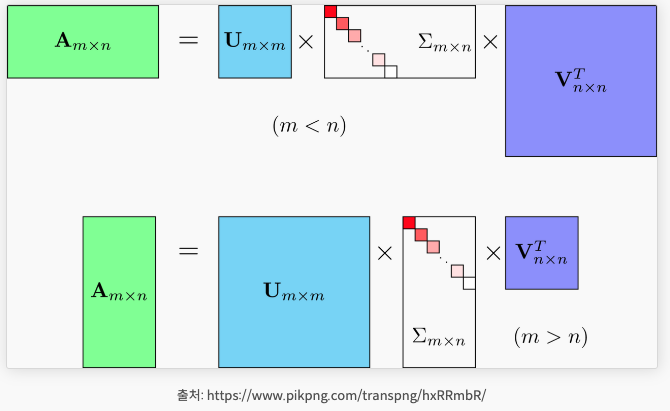

### Truncated SVD
- ∑의 비대각 부분과 대각 원소 중 특이값이 0인 부분을 모두 제거하고, 제거된 ∑에 대응되는 U와 V 원소도 함께 제거해 차원을 줄인 형태로 SVD를 적용합니다.
- 이런 방식을 Truncated SVD라고 합니다. 다시 말해 Truncated SVD는 ∑의 대각 원소 중 상위 몇 개만 추출하고 여기에 대응하는 U와 V의 원소도 함께 제거해 차원을 줄인 것입니다.
- ∑의 대각 원소 중 상위 t개만 추출한다고 하면 아래와 같이 분해됩니다.

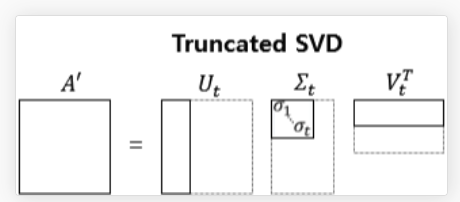

## 특이값 분해 및 복원 실습

In [34]:
np.random.seed(121)
# 4x4 행렬 a 생성
a = np.random.randn(4,4)
np.round(a,3)

array([[-0.212, -0.285, -0.574, -0.44 ],
       [-0.33 ,  1.184,  1.615,  0.367],
       [-0.014,  0.63 ,  1.71 , -1.327],
       [ 0.402, -0.191,  1.404, -1.969]])

특이값 분해

In [35]:
from numpy.linalg import svd

U, Sigma, Vt = svd(a) # 특이값 분행

print(U.shape, Sigma.shape, Vt.shape)
print('U matrix:\n',np.round(U, 3))
print('Sigma Value:\n',np.round(Sigma, 3))
print('V transpose matrix:\n',np.round(Vt, 3))

(4, 4) (4,) (4, 4)
U matrix:
 [[-0.079 -0.318  0.867  0.376]
 [ 0.383  0.787  0.12   0.469]
 [ 0.656  0.022  0.357 -0.664]
 [ 0.645 -0.529 -0.328  0.444]]
Sigma Value:
 [3.423 2.023 0.463 0.079]
V transpose matrix:
 [[ 0.041  0.224  0.786 -0.574]
 [-0.2    0.562  0.37   0.712]
 [-0.778  0.395 -0.333 -0.357]
 [-0.593 -0.692  0.366  0.189]]


복원

In [36]:
# Sima를 다시 0 을 포함한 대칭행렬로 변환
Sigma_mat = np.diag(Sigma)
a_ = np.dot(np.dot(U, Sigma_mat), Vt)
print(f'원본: {np.round(a,3)}')
print('-'*50)
print(f'복원: {np.round(a_, 3)}')

원본: [[-0.212 -0.285 -0.574 -0.44 ]
 [-0.33   1.184  1.615  0.367]
 [-0.014  0.63   1.71  -1.327]
 [ 0.402 -0.191  1.404 -1.969]]
--------------------------------------------------
복원: [[-0.212 -0.285 -0.574 -0.44 ]
 [-0.33   1.184  1.615  0.367]
 [-0.014  0.63   1.71  -1.327]
 [ 0.402 -0.191  1.404 -1.969]]


> 기존 a행렬과 값이 같은 것을 확인할 수 있다.

## Base model

- TruncatedSVD
> Sigma 행렬에 있는 대각원소, 즉 특이값 중 상위 일부 데이터(n_components)만 추출해 분해하는 방식이다.

In [37]:
sparse_features.shape[1]

330

In [38]:
reset_seeds()

from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=sparse_features.shape[1])
svd.fit(sparse_features)
sum(svd.explained_variance_ratio_)

0.9999999999999978

In [39]:
tmp = pd.DataFrame(svd.transform(sparse_features)).add_prefix("svd_")
x_train = pd.concat([features,tmp],axis=1)
print(f'after: {x_train.shape}')

after: (891, 332)


In [40]:
reset_seeds()

model = KNeighborsClassifier(n_neighbors=10) #LGBMClassifier(random_state=SEED)
scores = cross_val_score(model,x_train,y_train,cv = cv , scoring="roc_auc",n_jobs=-1)
print(f'score: {scores.mean()} / base_score: {base_score}')

score: 0.8160958779824352 / base_score: 0.815763031045441


## 주성분 2인 경우

In [41]:
reset_seeds()

svd2 = TruncatedSVD(n_components=2)
svd2.fit(sparse_features)
sum(svd2.explained_variance_ratio_)

0.2121289050304349

In [42]:
tmp = pd.DataFrame(svd2.transform(sparse_features)).add_prefix("svd_")
x_train = pd.concat([features,tmp],axis=1)
print(f'after: {x_train.shape}')

after: (891, 4)


In [43]:
reset_seeds()

model = KNeighborsClassifier(n_neighbors=10)
scores = cross_val_score(model,x_train,y_train,cv = cv , scoring="roc_auc",n_jobs=-1)
print(f'score: {scores.mean()} / base_score: {base_score}')

score: 0.7958265580897994 / base_score: 0.815763031045441


## 주성분 15인 경우

In [44]:
reset_seeds()

svd15 = TruncatedSVD(n_components=15)
svd15.fit(sparse_features)
sum(svd15.explained_variance_ratio_)

0.7264569242686382

In [45]:
tmp = pd.DataFrame(svd15.transform(sparse_features)).add_prefix("svd_")
x_train = pd.concat([features,tmp],axis=1)
print(f'after: {x_train.shape}')

after: (891, 17)


In [46]:
reset_seeds()

model = KNeighborsClassifier(n_neighbors=10)
scores = cross_val_score(model,x_train,y_train,cv = cv , scoring="roc_auc",n_jobs=-1)
print(f'score: {scores.mean()} / base_score: {base_score}')

score: 0.8261155150538982 / base_score: 0.815763031045441


# [비음수 행렬 분해(NMF; Non-negative Matrix Factorization)](https://angeloyeo.github.io/2020/10/15/NMF.html)

음수 미포함 행렬 분해(Non-negative Matrix Factorization, NMF)는 음수를 포함하지 않는 행렬 X를 음수를 포함하지 않는 행렬 W와 H의 곱으로 분해하는 알고리즘이다.
$$
X = WH
$$

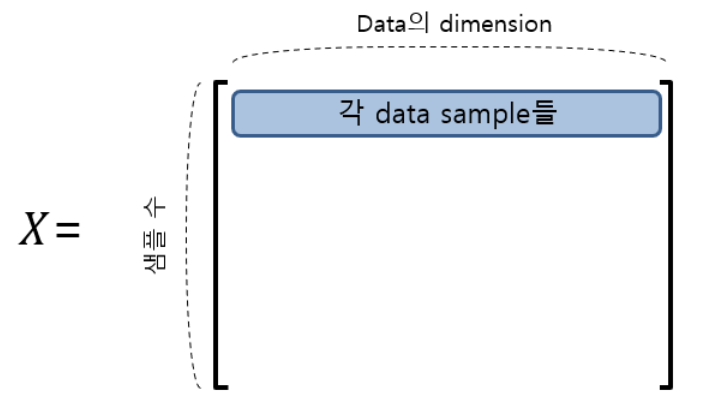

만약 p개의 feature를 가지고 원래의 데이터셋 X를 분해하고 싶다고 하면,    
- $W \in R^{m,p}$
- $H \in R{p,n}$

이렇게 분해해주게 되었을 때 우선 H부터 생각해보면 H의 각 행은 하나의 feature가 되며, W의 한 행은 각각의 feature들을 얼마만큼 섞어 쓸 것인지에 관한 weight의 의미를 갖게 된다.

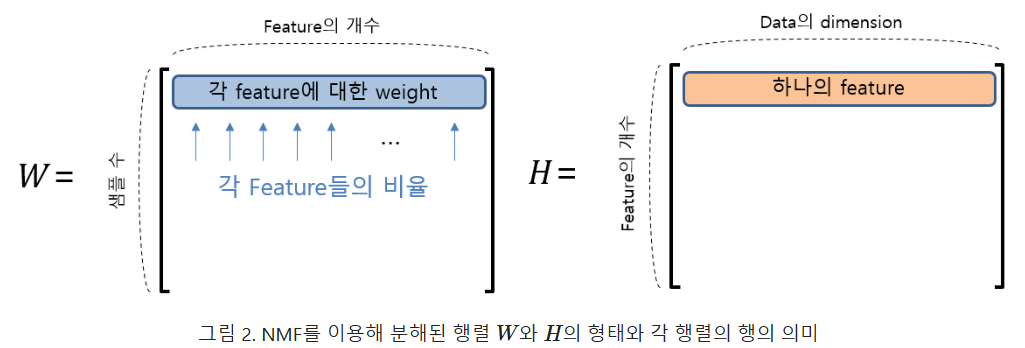

### NMF의 장점
- 현실 세계의 데이터들 중 상당수는 음의 값이 포함되지 않는다. (예를 들어 그림의 경우 모든 데이터들은 pixel의 세기로 구성되어 있고, 이 값들 중 음수는 없다.)
- 그런데 많은 경우에 사용되는 matrix factorization 방법들(가령, SVD)이나 차원 축소 방법(가량, PCA)에서는 획득할 수 있는 feature들이 음의 값을 갖는 경우가 존재한다.
- 하지만 NMF는 이들 중에서 유일하게 non-negative feature들을 추출하기 때문에 큰 장점으로 볼 수 있다.

### PCA와 NMF의 차이
PCA(또는 SVD)는 feature들 간의 직교성이 보장된다. 즉 전체 데이터의 구조를 설명하는 것에 한계가 있다.

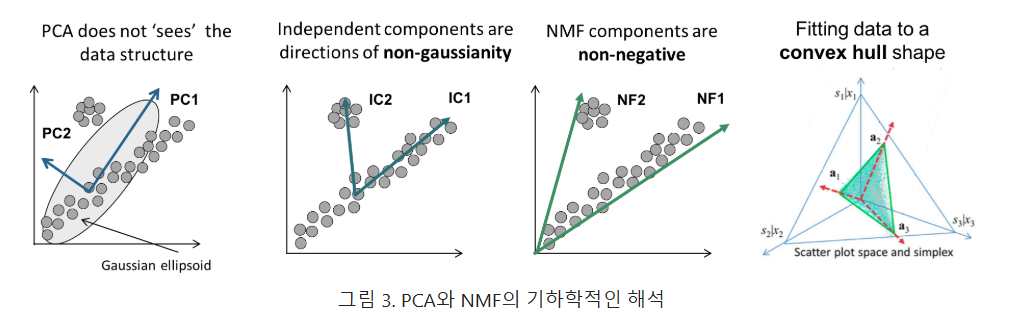

## Base model

In [47]:
reset_seeds()

from sklearn.decomposition import NMF

nmf = NMF(n_components=sparse_features.shape[1], max_iter=500)
nmf.fit(sparse_features)

/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(


NMF(max_iter=500, n_components=330)

In [48]:
(nmf.components_ < 0).sum(), nmf.components_.shape

(0, (330, 330))

In [49]:
tmp = pd.DataFrame(nmf.transform(sparse_features)).add_prefix("nmf_")
x_train = pd.concat([features,tmp],axis=1)
print(f'after: {x_train.shape}')

after: (891, 332)


In [50]:
reset_seeds()

model = KNeighborsClassifier(n_neighbors=10)
scores = cross_val_score(model,x_train,y_train,cv = cv , scoring="roc_auc",n_jobs=-1)
print(f'score: {scores.mean()} / base_score: {base_score}')

score: 0.7468688407473739 / base_score: 0.815763031045441


## 주성분 5인 경우

In [51]:
reset_seeds()

nmf5 = NMF(n_components=5, max_iter=500)
nmf5.fit(sparse_features)

NMF(max_iter=500, n_components=5)

In [52]:
(nmf5.components_ < 0).sum(), nmf5.components_.shape

(0, (5, 330))

In [53]:
tmp = pd.DataFrame(nmf5.transform(sparse_features)).add_prefix("nmf_")
x_train = pd.concat([features,tmp],axis=1)
print(f'after: {x_train.shape}')

after: (891, 7)


In [54]:
reset_seeds()

model = KNeighborsClassifier(n_neighbors=10)
scores = cross_val_score(model,x_train,y_train,cv = cv , scoring="roc_auc",n_jobs=-1)
print(f'score: {scores.mean()} / base_score: {base_score}')

score: 0.7199486147184602 / base_score: 0.815763031045441


## 주성분 250인 경우

In [71]:
reset_seeds()

nmf250 = NMF(n_components=250, max_iter=500)
nmf250.fit(sparse_features)

/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(


NMF(max_iter=500, n_components=250)

In [72]:
(nmf250.components_ < 0).sum(), nmf250.components_.shape

(0, (250, 330))

In [73]:
tmp = pd.DataFrame(nmf250.transform(sparse_features)).add_prefix("nmf_")
x_train = pd.concat([features,tmp],axis=1)
print(f'after: {x_train.shape}')

after: (891, 252)


In [74]:
reset_seeds()

model = KNeighborsClassifier(n_neighbors=10)
scores = cross_val_score(model,x_train,y_train,cv = cv , scoring="roc_auc",n_jobs=-1)
print(f'score: {scores.mean()} / base_score: {base_score}')

score: 0.7473934153860023 / base_score: 0.815763031045441
